In [1]:
devtools::install_github("clairbarnes/rwwa")
library(rwwa)

Skipping install of 'rwwa' from a github remote, the SHA1 (1beba54e) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: extRemes

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot


Loading required package: plyr


Attaching package: ‘plyr’


The following object is masked from ‘package:distillery’:

    is.formula




---
# Trend fitting - HighResMIP

## GMST + Nino3.4

In [88]:
# load GSAT covariate to be used where model's own GSAT is not available
ens_gsat <- load_ts("~/00_WWA_project_folder/live/data/highresmip/GSAT/GSAT-smoothed_highresmip_mean.dat", col.names = c("year", "gmst"))
ens_gsat$gmst <- ens_gsat$gmst - ens_gsat$gmst[ens_gsat$year == 2024]

In [89]:
# load Nino covariate & standardise wrt obs period
nino <- load_ts("~/00_WWA_project_folder/live/data/highresmip/Nino3.4/nino3.4-detrended_highresmip_DJF.dat", col.names = c("year", "nino"))
nino$year <- nino$year + 1 # relabel years to align with April-May obs

nino_cal <- nino$nino[(nino$year >= 1979) & (nino$year <= 2024)]
nino$nino_std <- (nino$nino - mean(nino_cal)) / sd(nino_cal)

# also get standardised observed Nino, for factual climate
nino_obs <- read.csv("~/wwa/10_misc/detrended_nino34/nino_djf.csv", col.names = c("year", "nino"))
nino_cal <- nino_obs$nino[(nino_obs$year >= 1979) & (nino_obs$year <= 2024)]
nino_obs$nino_std <- (nino_obs$nino - mean(nino_cal)) / sd(nino_cal)

nino_2024 <- nino_obs$nino_std[nino_obs$year == 2024]

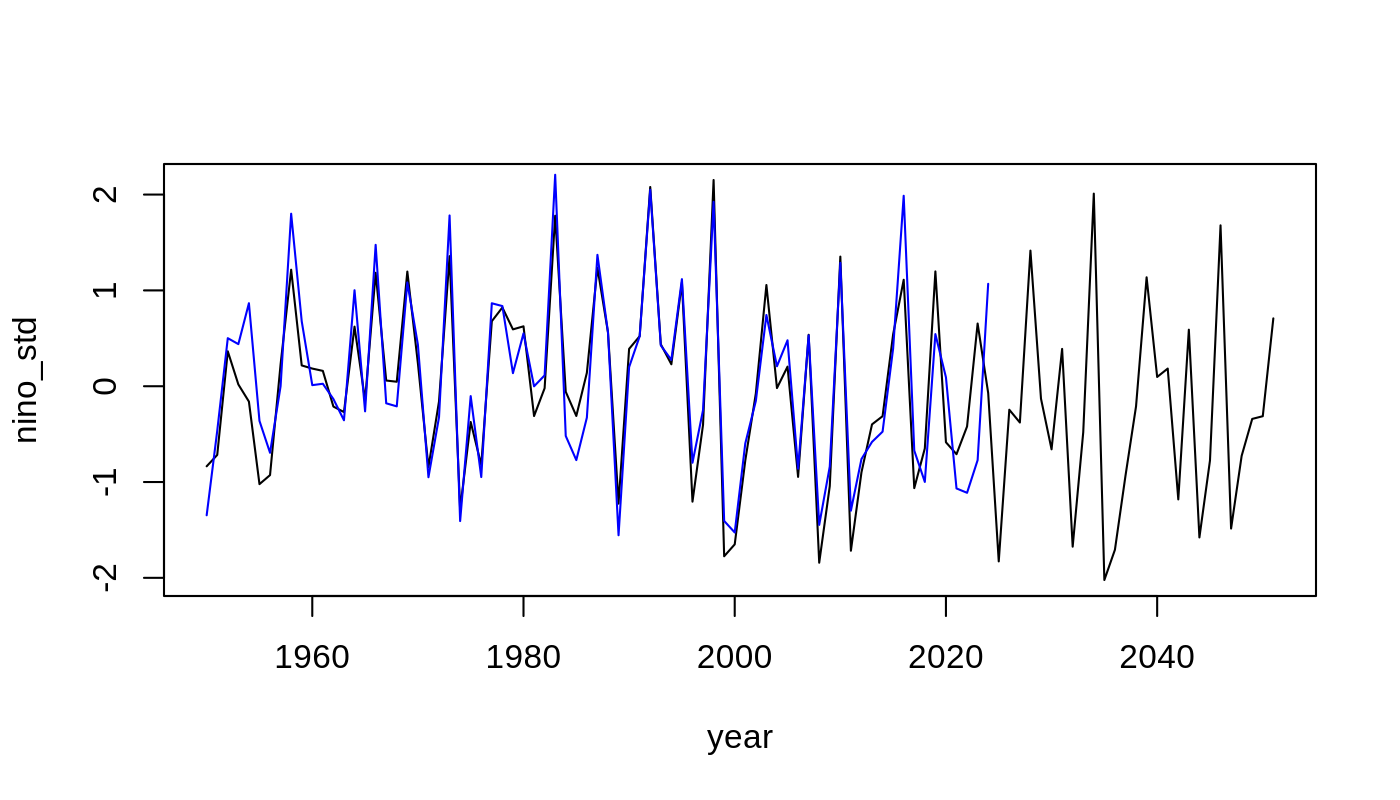

In [90]:
# quick visual check that standardised Nino series looks right
prep_window(w = 7)
plot(nino[,c("year", "nino_std")], type = "l")
lines(nino_obs[nino_obs$year >= 1950,c("year", "nino_std")], col = "blue")

In [95]:
rp = 10
nsamp = 1000

fl = list.files("ts_highresmip", pattern = "pr-am", full.names = T)
for (fnm in fl) {
    
    ts <- load_ts(fnm, col.names = c("year", "pr"))
    
    gmst_fnm <- list.files("~/00_WWA_project_folder/live/data/highresmip/GSAT", pattern = paste0(gsub(".dat","_",strsplit(fnm, "_")[[1]][5]), "r1i1p1f1"), full.names = T)
    if(length(gmst_fnm) == 0) {
        gmst <- ens_gsat
    } else {
        gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
        gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]
    }
    
    # combine all covariates with time series
    df <- merge(ts, merge(gmst, nino))
    
    mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino_std"), lower = F)
    
    res_fnm <- gsub(".dat", ".csv", gsub("ts_highresmip/", "res/", fnm))
    
    if(!file.exists(res_fnm)) {
        
        cov_now <- data.frame("gmst" = 0, "nino_std" = nino_2024)
        cov_cf <- rbind("pi" = data.frame("gmst" = - 1.2, "nino_std" = nino_2024), 
                        "neut" = data.frame("gmst" = 0, "nino_std" = 0))
        cov_fut <- data.frame("gmst" = 0.8, "nino_std" = nino_2024)
        
        # bootstrap results
        res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_cf, cov_fut = cov_fut,
                              y_now = 2024, y_start = 1979, y_fut = 2050, nsamp = nsamp)
        
        # bootstrap correlation between Nino & precip in this region
        set.seed(42)
        nino_corr <- c(cor(df$nino, df$pr), 
                       quantile(sapply(1:nsamp, function(i) cor(df[sample(1:nrow(mdl$data), replace = T), c("nino", "pr")])[1,2]), c(0.025, 0.975)))
        nino_corr <- setNames(data.frame(t(nino_corr)), paste0("nino-corr_", c("est", "lower", "upper")))
                                       
        res <- cbind(nino_corr, res)
        write.csv(res, res_fnm)
    }
    
    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res/", "mdl-eval/rlplot_", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 480, w = 480 * 2); par(cex.main = 1.4, mfrow = c(1,2), oma = c(0,0,2,0)); {
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_cf["pi",,drop = F], nsamp = 100, main = "Present vs PI")
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_cf["neut",,drop = F], nsamp = 100, main ="Present vs neutral Nino3.4")
            mtext(outer = T, gsub(".dat","",paste0(strsplit(fnm, "_")[[1]][4:6], collapse = "_")), font = 2, cex = 1.5)
        }; dev.off()
    }
}

In [96]:
# compile results
res <- t(sapply(list.files("res", pattern = "pr-am_highresmip", full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(rnm) gsub(".csv", "", strsplit(rnm, "_")[[1]][4]))
write.csv(res, "res_pr-am_gmst-nino_highresmip.csv")

---
# Trend fitting - obs


## CRU

In [30]:
nino <- read.csv("~/wwa/10_misc/detrended_nino34/nino_djf.csv", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]


df <- merge(gmst, nino)
cov_2024 <- df[df$year == 2024,c("gmst", "nino")]
cov_cf <- rbind("pi" = cov_2024 - c(1.2, 0), "neut" = c(0,0))

ts <- read.csv("ts/cru_am.csv", col.names = c("year", "pr"))
df <- merge(df, ts)

In [33]:
# fit initial model & use to get pseudo-event value for 10-year return period under current conditions
mdl_init <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = F)
ev <- eff_return_level(mdl_init, rp = 10, fixed_cov = cov_2024)

In [34]:
# now fit the final model, including event details (needed for plotting etc)
mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = F, ev_year = 2024, ev = ev)

In [55]:
nsamp <- 1000
res <- boot_ci(mdl, cov_f = cov_2024, cov_cf = cov_cf, nsamp = nsamp)

set.seed(42)
nino_corr <- c(cor(df$nino, df$pr), 
               quantile(sapply(1:nsamp, function(i) cor(df[sample(1:nrow(mdl$data), replace = T), c("nino", "pr")])[1,2]), c(0.025, 0.975)))

res <- cbind(nino_corr, res)

In [57]:
write.csv(res, "res/Afghanistan-floods_pr-am_obs_cru.csv")

In [61]:
mdl_1979 <- fit_ns("norm", "fixeddisp", df[df$year >= 1979,], "pr", c("gmst", "nino"), lower = F)

In [62]:
eff_return_level(mdl_1979, rp = 10, fixed_cov = cov_2024)

[1] 44.78412

## Compare datasets

In [113]:
nino <- read.csv("~/wwa/10_misc/detrended_nino34/nino_djf.csv", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

df <- merge(gmst, nino)
cov_2024 <- df[df$year == 2024,c("gmst", "nino")]
cov_cf <- rbind("pi" = cov_2024 - c(1.2, 0), "neut" = c(0,0))

In [114]:
cru = merge(df, read.table("ts/CRUTS_AMseasonal_AfghIranPak.txt", col.names = c("year", "pr")))
era5 = merge(df, load_ts("ts/Afghanistan-floods_pr-am_obs_era5.dat", col.names = c("year", "pr")))
mswep = merge(df, read.table("ts/MSWEP_AMseasonal_AfghIranPak.dat", col.names = c("year", "pr")))
gpcc = merge(df, load_ts("ts/Afghanistan-floods_pr-am_obs_gpcc.dat", col.names = c("year", "pr")))

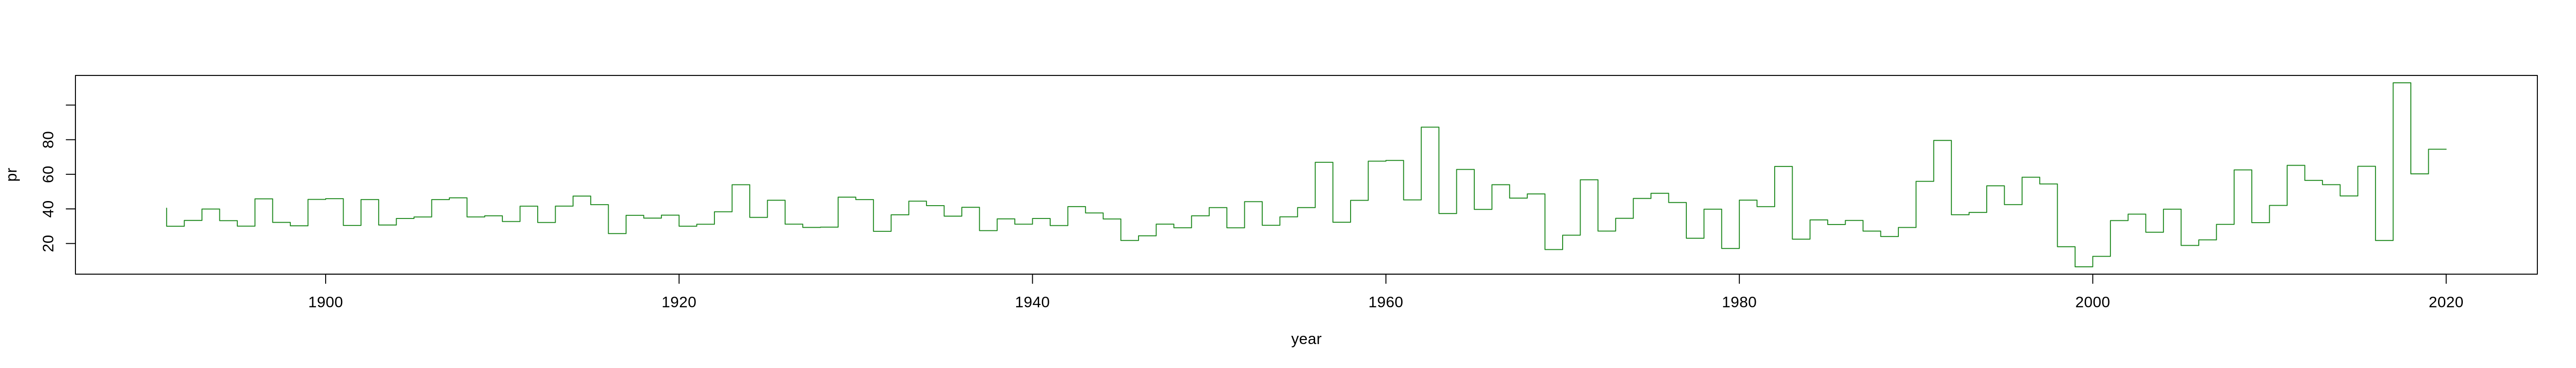

In [120]:
plot(gpcc[,c("year", "pr")], type = "S", col = "forestgreen")

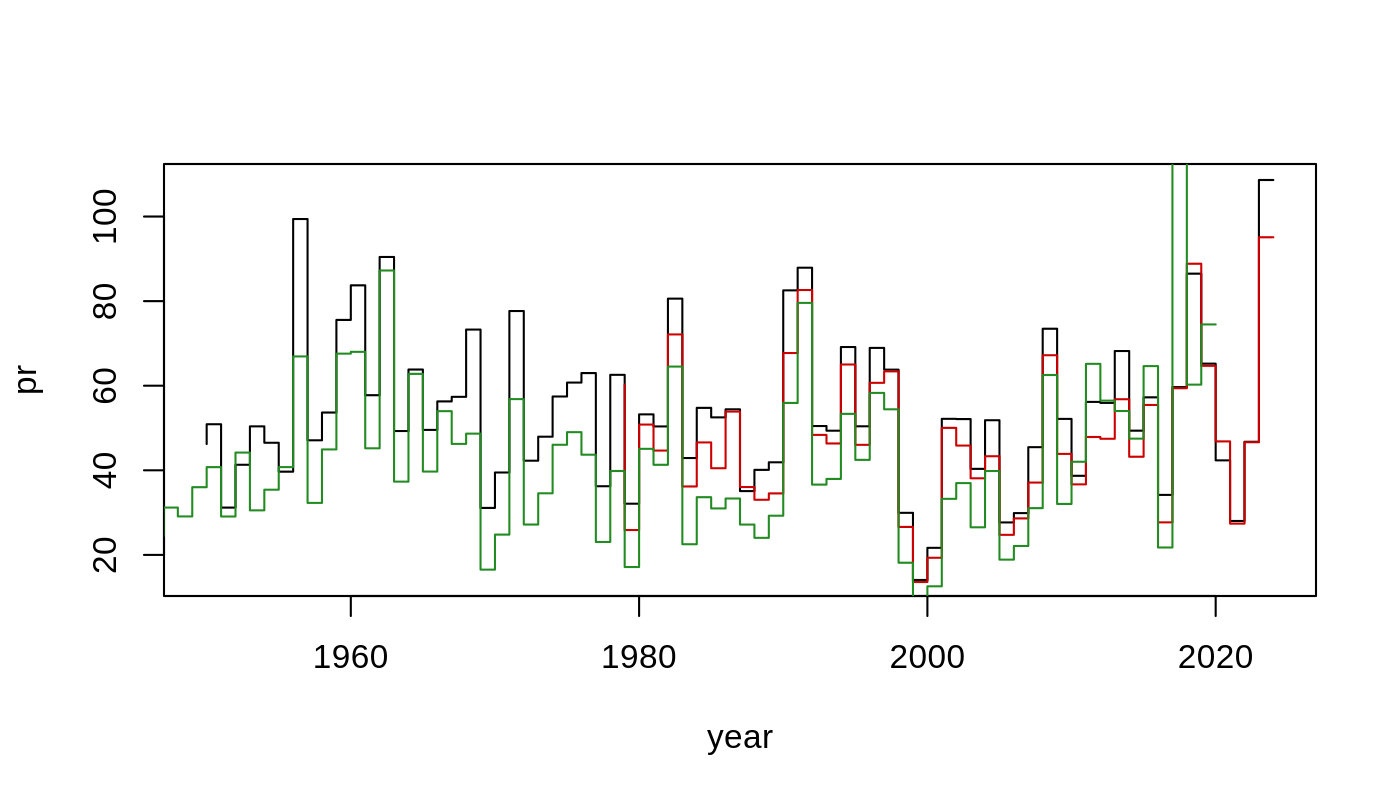

In [116]:
prep_window(w = 7)
plot(era5[,c("year", "pr")], type = "S", col = "black")
lines(mswep[,c("year", "pr")], type = "S", col = "red3")
# lines(cru[,c("year", "pr")], type = "S", col = "blue")
lines(gpcc[,c("year", "pr")], type = "S", col = "forestgreen")

In [118]:
cru$log_pr <- log(cru$pr); era5$log_pr <- log(era5$pr); mswep$log_pr <- log(mswep$pr); gpcc$log_pr <- log(gpcc$pr);

datasets <- list("era5" = era5, "mswep" = mswep, "cru" = cru, "gpcc" = gpcc)

models <- sapply(datasets, function(ds) fit_ns("norm", "fixeddisp", ds, "pr", c("gmst", "nino"), lower = F), simplify = F)
models_log <- sapply(datasets, function(ds) fit_ns("norm", "fixeddisp", ds, "log_pr", c("gmst", "nino"), lower = F), simplify = F)
models_1979 <- sapply(datasets, function(ds) fit_ns("norm", "fixeddisp", ds[ds$year >=1979,], "pr", c("gmst", "nino"), lower = F), simplify = F)
models_log1979 <- sapply(datasets, function(ds) fit_ns("norm", "fixeddisp", ds[ds$year >=1979,], "log_pr", c("gmst", "nino"), lower = F), simplify = F)

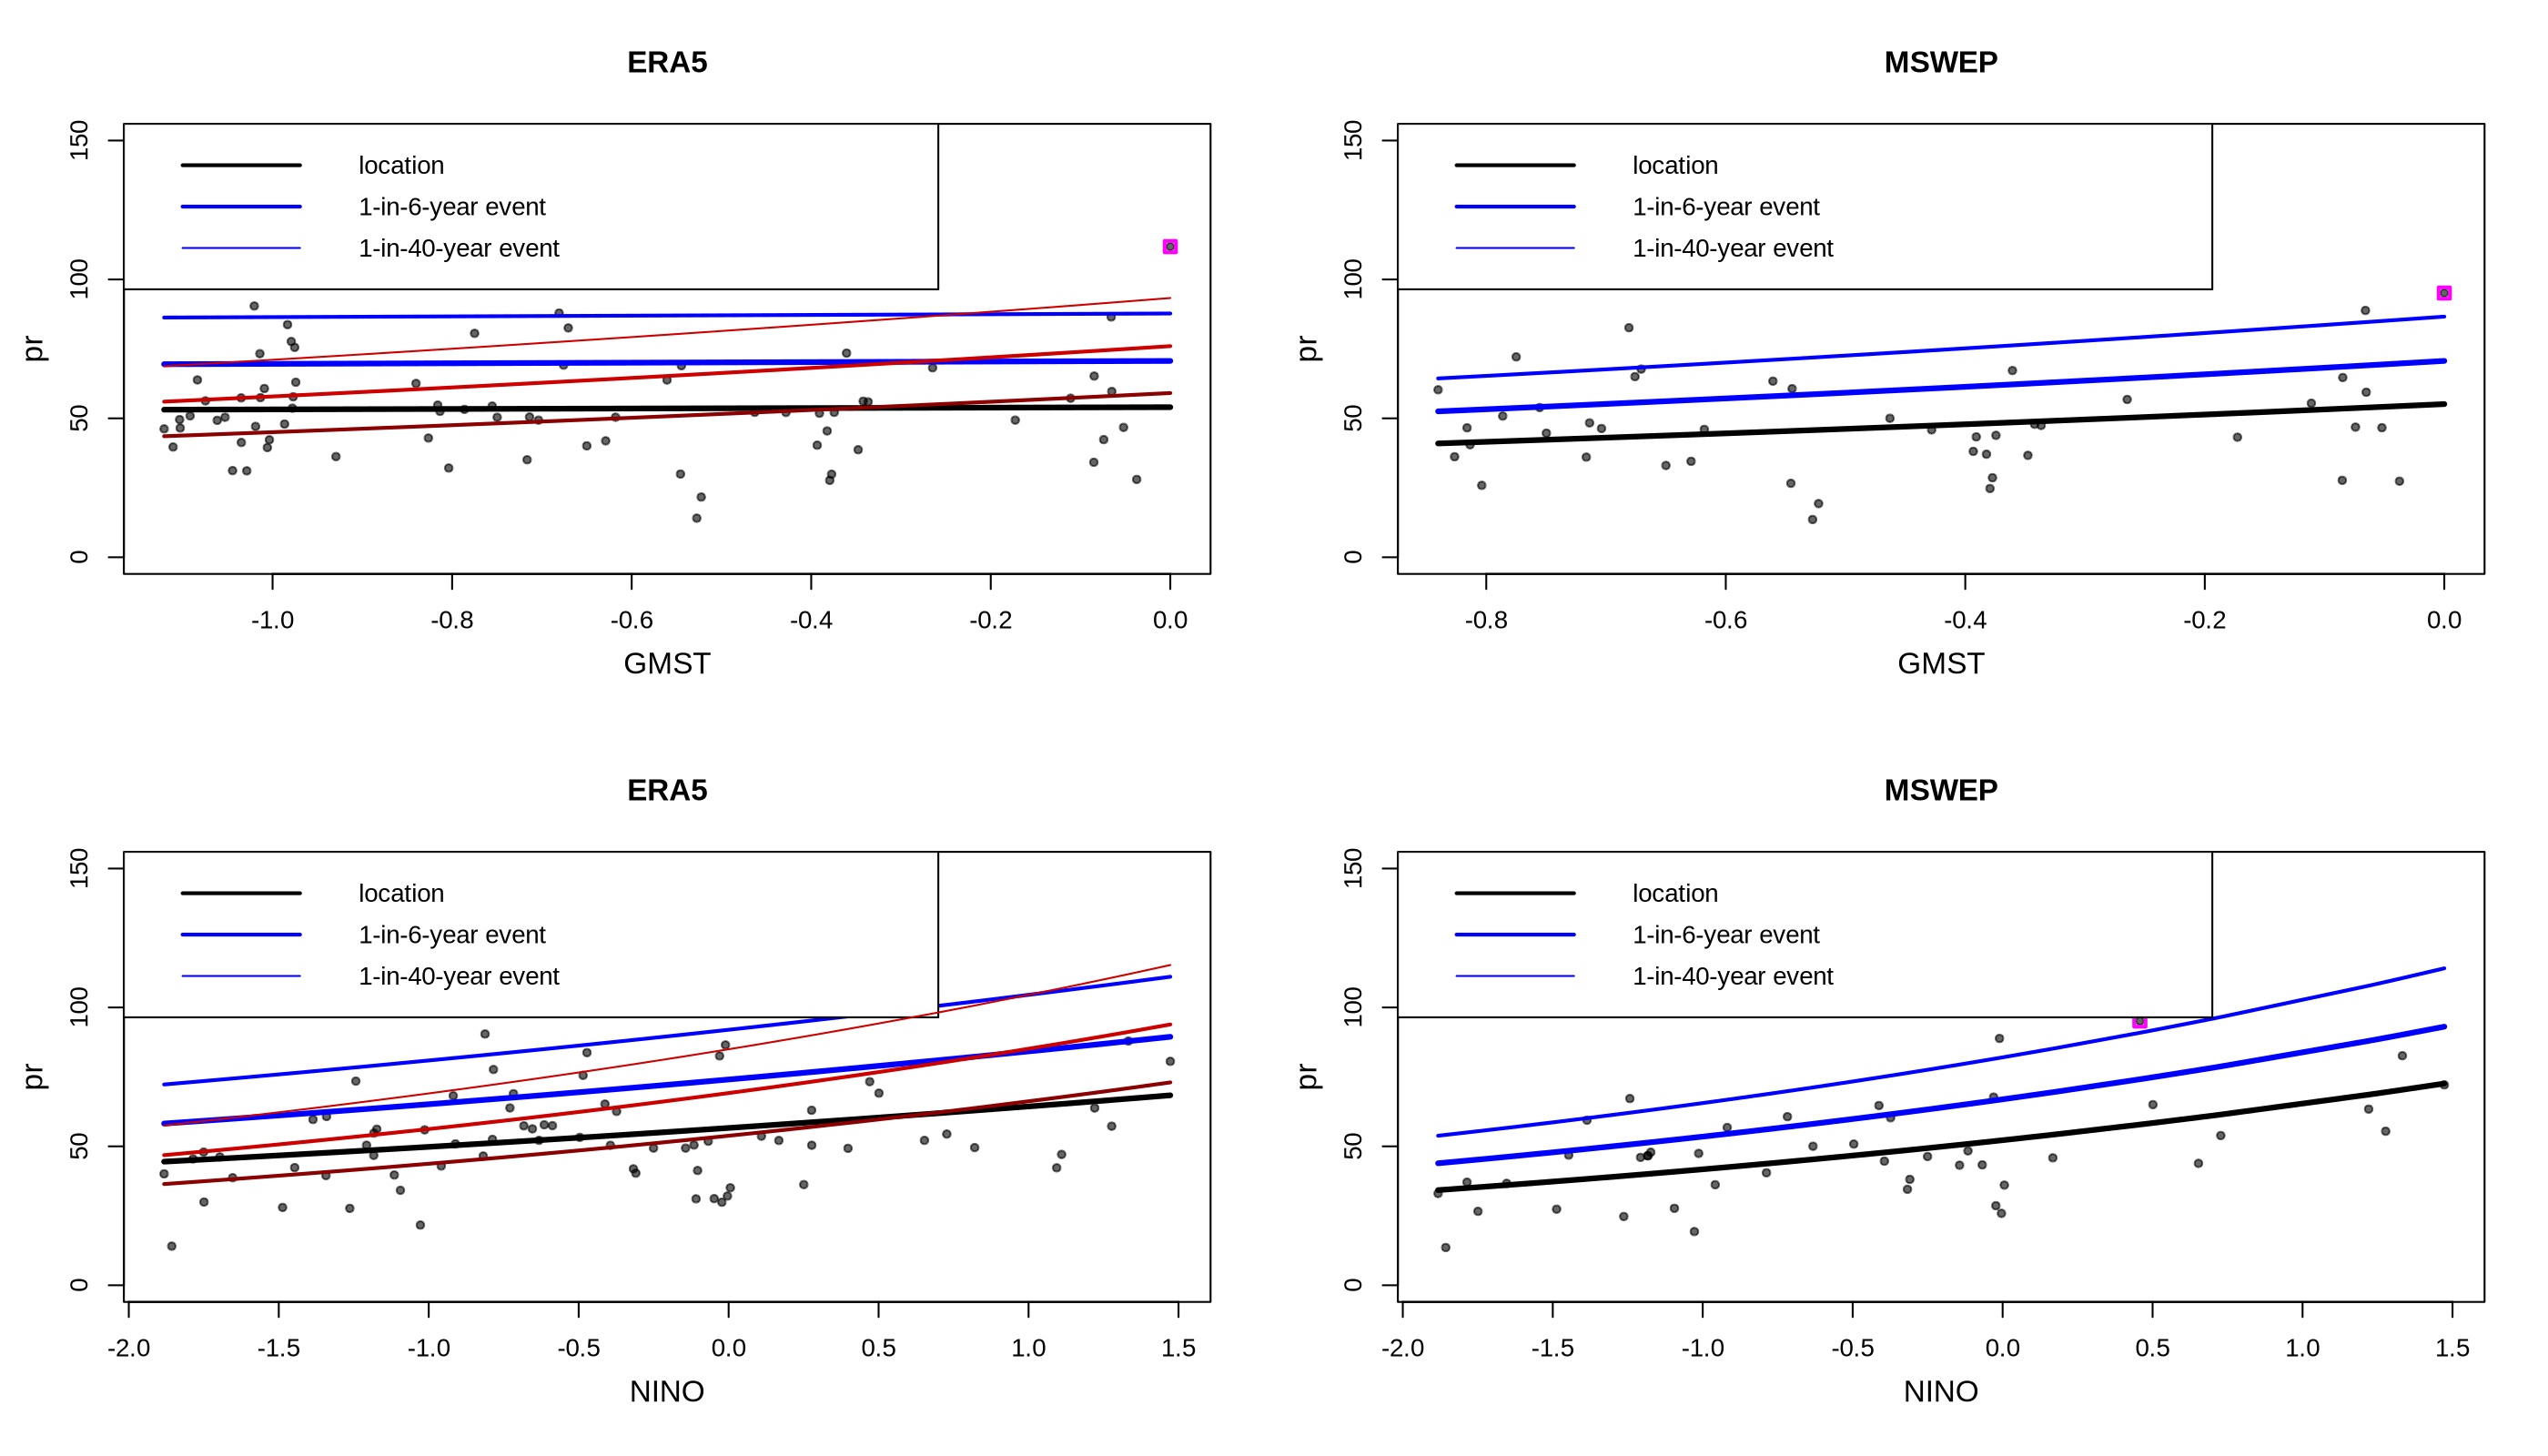

In [90]:
prep_window(c(2,2), w = 7)

ylim = c(0,150)

plot_covtrend(models[["era5"]], "gmst", main = "ERA5", ylim = ylim)
era5_gmstcov <- data.frame(gmst = era5$gmst, nino = mean(era5$nino))
lines(era5$gmst, ns_pars(models_1979[["era5"]], fixed_cov = era5_gmstcov)$loc, col = "darkred", lwd = 2)
lines(era5$gmst, eff_return_level(models_1979[["era5"]], 6, fixed_cov = era5_gmstcov), col = "red3", lwd = 2)
lines(era5$gmst, eff_return_level(models_1979[["era5"]], 40, fixed_cov = era5_gmstcov), col = "red3", lwd = 1)

plot_covtrend(models[["mswep"]], "gmst", main = "MSWEP", ylim = ylim)

plot_covtrend(models[["era5"]], "nino", main = "ERA5", ylim = ylim)
era5_ninocov <- data.frame(gmst = mean(era5$gmst), nino = era5$nino)[order(era5$nino),]
lines(era5_ninocov$nino, ns_pars(models_1979[["era5"]], fixed_cov = era5_ninocov)$loc, col = "darkred", lwd = 2)
lines(era5_ninocov$nino, eff_return_level(models_1979[["era5"]], 6, fixed_cov = era5_ninocov), col = "red3", lwd = 2)
lines(era5_ninocov$nino, eff_return_level(models_1979[["era5"]], 40, fixed_cov = era5_ninocov), col = "red3", lwd = 1)

plot_covtrend(models[["mswep"]], "nino", main = "MSWEP", ylim = ylim)



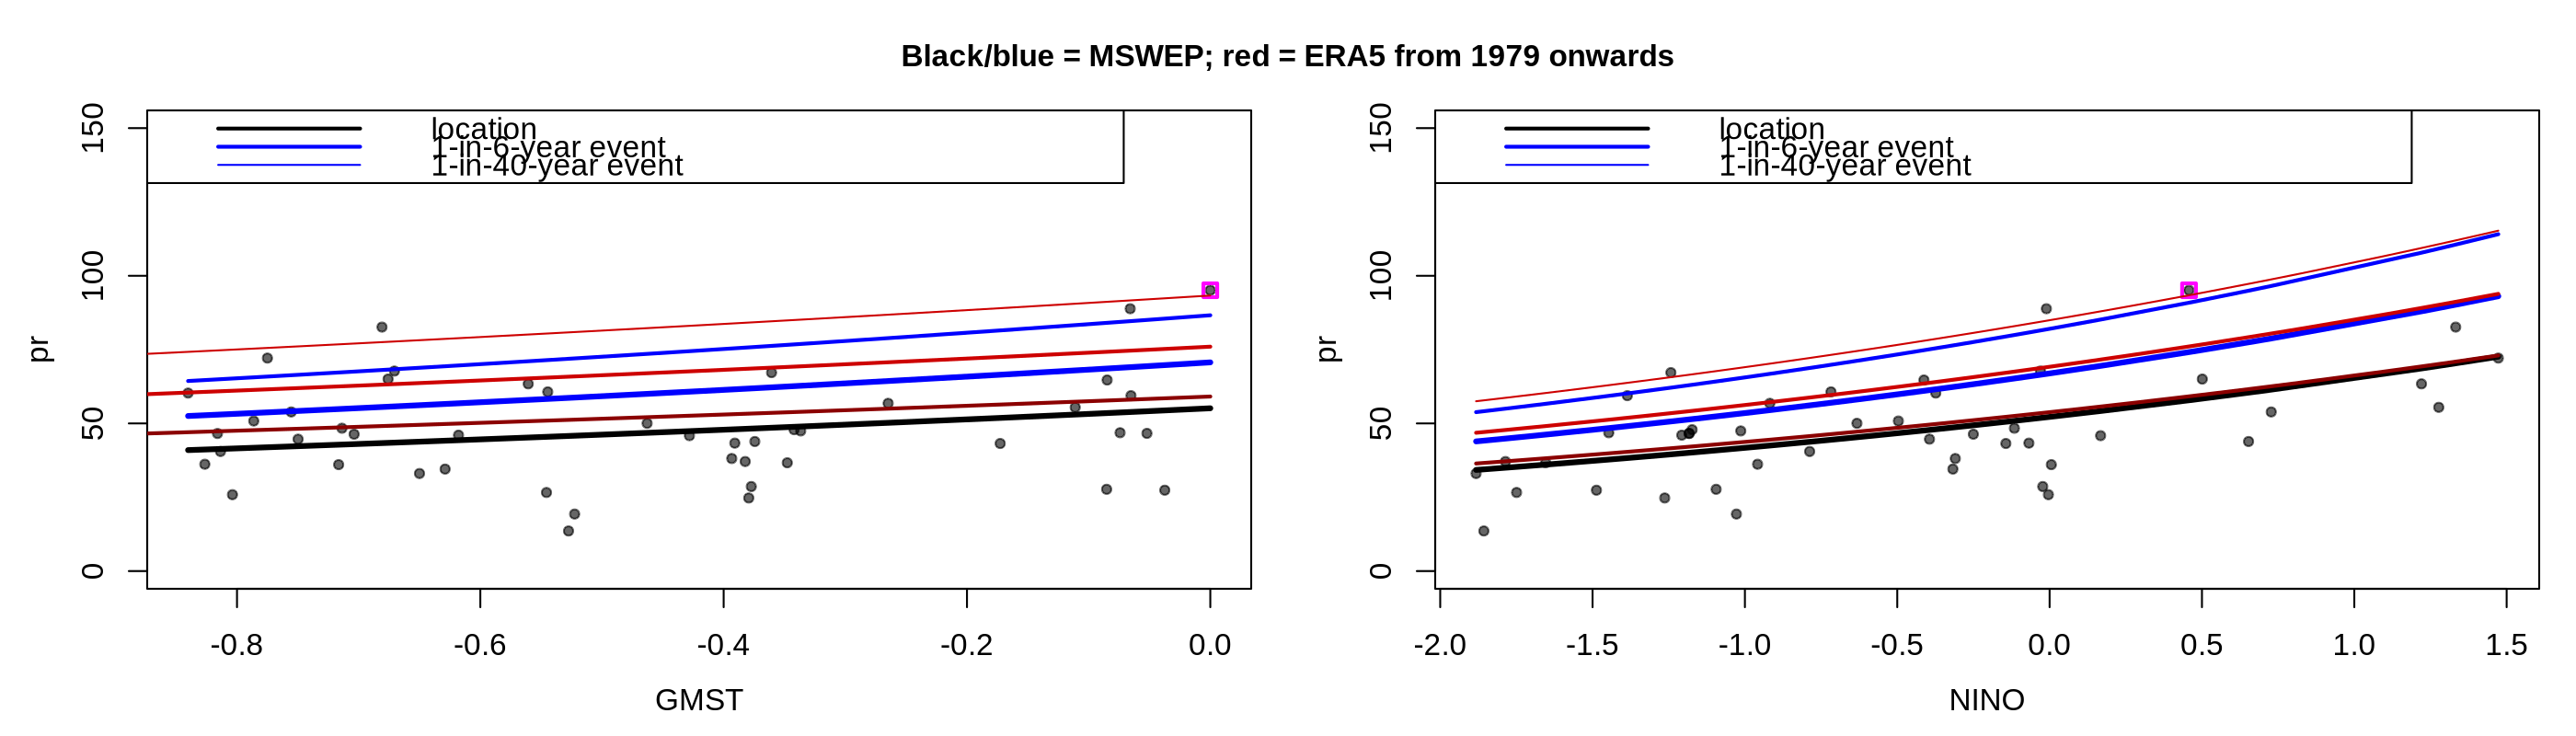

In [98]:
prep_window(c(1,2), w = 7, oma = c(0,0,2,0), mar = c(4,4,1,1))

ylim = c(0,150)

plot_covtrend(models[["mswep"]], "gmst", main = "", ylim = ylim)
era5_gmstcov <- data.frame(gmst = era5$gmst, nino = mean(era5$nino))
lines(era5$gmst, ns_pars(models_1979[["era5"]], fixed_cov = era5_gmstcov)$loc, col = "darkred", lwd = 2)
lines(era5$gmst, eff_return_level(models_1979[["era5"]], 6, fixed_cov = era5_gmstcov), col = "red3", lwd = 2)
lines(era5$gmst, eff_return_level(models_1979[["era5"]], 40, fixed_cov = era5_gmstcov), col = "red3", lwd = 1)

plot_covtrend(models[["mswep"]], "nino", main = "", ylim = ylim)
era5_ninocov <- data.frame(gmst = mean(era5$gmst), nino = era5$nino)[order(era5$nino),]
lines(era5_ninocov$nino, ns_pars(models_1979[["era5"]], fixed_cov = era5_ninocov)$loc, col = "darkred", lwd = 2)
lines(era5_ninocov$nino, eff_return_level(models_1979[["era5"]], 6, fixed_cov = era5_ninocov), col = "red3", lwd = 2)
lines(era5_ninocov$nino, eff_return_level(models_1979[["era5"]], 40, fixed_cov = era5_ninocov), col = "red3", lwd = 1)

mtext("Black/blue = MSWEP; red = ERA5 from 1979 onwards", outer = T, font = 2)


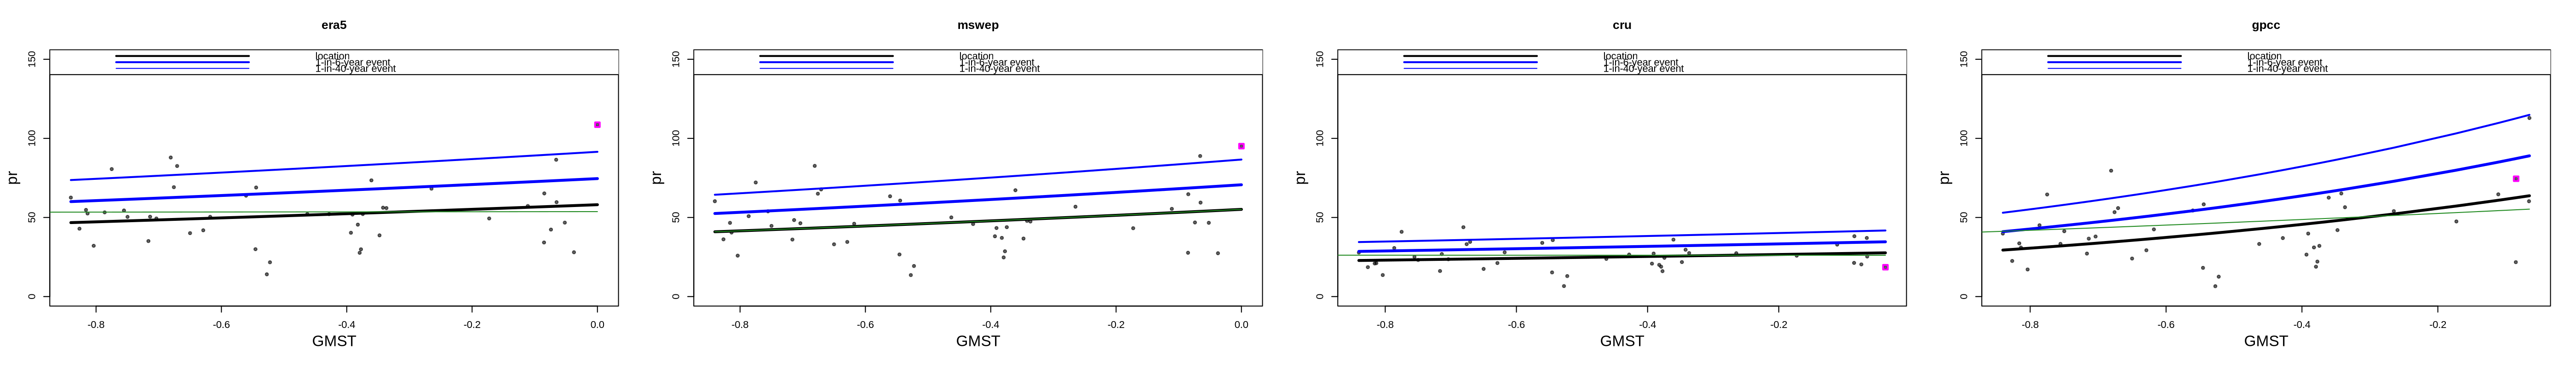

In [119]:
prep_window(c(1,length(datasets)), w = 7)

ylim = c(0,150)

for(ds in names(datasets)) {
    plot_covtrend(models_1979[[ds]], "gmst", main = ds, ylim = ylim)
    
    mdl <- models[[ds]]
    gmstcov <- data.frame(gmst = mdl$data$gmst, nino = mean(mdl$data$nino))
    lines(gmstcov$gmst, ns_pars(mdl, fixed_cov = gmstcov)$loc, col = "forestgreen")
}